**Importing dependencies**

In [ ]:
!pip install pennylane --upgrade
!pip install qiskit[visualization]

In [ ]:
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import Optimizer
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
np.random.seed(42)
format_value = "{:.3f}"

# array of Pauli matrices (will be useful later)
Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
Paulis[0] = torch.tensor([[0, 1], [1, 0]])
Paulis[1] = torch.tensor([[0, -1j], [1j, 0]])
Paulis[2] = torch.tensor([[1, 0], [0, -1]])

**Generating target GHZ or W states**

In [ ]:
# number of qubits in the circuit
nr_qubits = 5
# number of layers in the circuit
nr_layers = 3

# Generating 3 qubit GHZ target state
# mode = "ghz_target"
zeros_n = np.zeros((2**nr_qubits,))
zeros_n[0] = 1
ones_n = np.zeros((2**nr_qubits,))
ones_n[2**nr_qubits-1] = 1
ghz_target_state = torch.tensor((1/np.sqrt(2)) * (zeros_n - ones_n), \
                            requires_grad=False, dtype=torch.complex128)
# print(target_state)


**Templating circuit ansatz**

In [ ]:
# a layer of the circuit ansatz
def layer(params):
    for i in range(nr_qubits):
        qubit_params = params[3*i : 3*(i+1)]
        qml.RX(qubit_params[0], wires=i)
        qml.RY(qubit_params[1], wires=i)
        qml.RZ(qubit_params[2], wires=i)

    # ring CNOT gates
    for j in range(nr_qubits-1):
      for k in range(j+1,nr_qubits):
        if j+1<nr_qubits:
          qml.CNOT(wires=[j,k])


dev = qml.device("default.qubit",  wires=nr_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def train_circuit(params):
    # repeatedly apply each layer in the circuit
    for j in range(nr_layers):
        layer_params = params[3*nr_qubits*j : 3*nr_qubits*(j+1)]
        layer(layer_params)
    return qml.state()

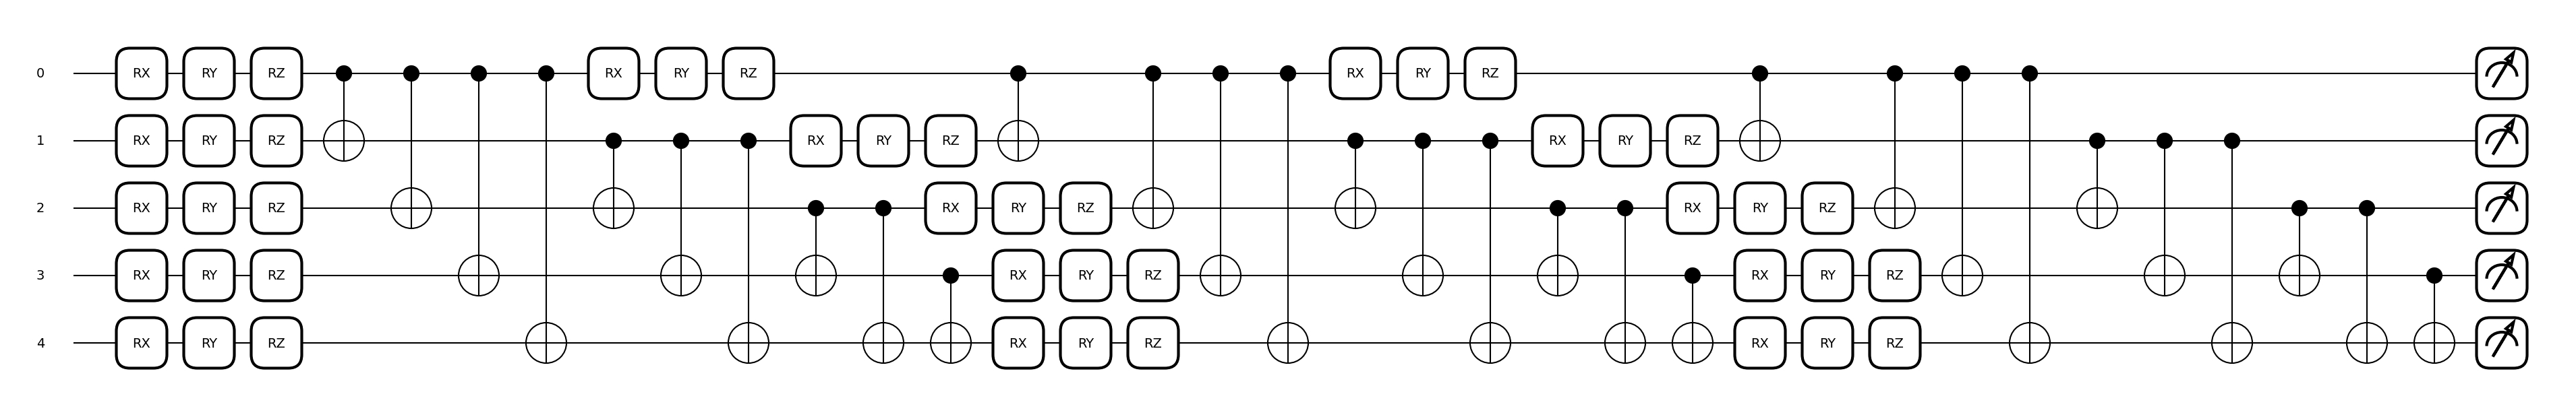

In [ ]:
disp_params = torch.tensor(np.random.normal(-np.pi, np.pi, (nr_qubits*nr_layers*3,)))
# Ansatz verification
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(train_circuit)(disp_params)
plt.show()

**Custom optim code**

In [ ]:
class IPGDescent(Optimizer):
    """
    STEP 1 - Do SGD
    read grad and backward
    STEP 2 - Write the hessian module - Newton
    STEP 3 - Precondition
    """

    def __init__(self, parameters, lr=1e-3):
        defaults = {"lr": lr}
        super().__init__(parameters, defaults)

        # for p in self.get_params():
        #     self.state[p] = {}

        self.state["n"] = parameters[0].size(dim=0)
        self.state["iter"] = 0
        self.state["norm_grad_hist"] = []
        # self.state["curr_K"] = torch.zeros(self.state["n"], self.state["n"], \
        #                                    requires_grad=False, dtype=torch.float64)
        self.state["curr_K"] = torch.eye(self.state["n"], dtype=torch.float64)
        # self.state["K_hist"] = [self.state["curr_K"]]
        self.state["curr_alpha"] = 1e-2
        self.state["curr_beta"] = 5
        self.state["alpha_hist"] = [self.state["curr_alpha"]]
        self.state["beta_hist"] = [self.state["curr_beta"]]
        self.state["delta"] = 1e-1
        self.state["Id"] = torch.eye(self.state["n"], dtype=torch.float64)


    def step(self, function, closure=None):
        """
        Work with p being a 1D param tensor
        """
        loss = None
        if closure is not None:
            loss = closure()

        self.state["iter"] += 1

        # print("=================================================================")
        print("self.state[iter] = ", self.state["iter"])
        # print("=================================================================")
        # print("get params output - ", self.get_params())
        # print("=================================================================")
        # print("param_groups - ", self.param_groups)

        # self.zero_hessian()
        # self.set_hessian()

        for group in self.param_groups:
          for p in group['params']:

            # grad and hessian calc
            grad = torch.func.grad(function, argnums=0)(p)
            # print("grad - ", grad)
            # print("grad dtype - ", grad.dtype)
            norm = torch.linalg.vector_norm(grad).detach().item()
            print("norm_gf = ", format_value.format(norm))
            self.state["norm_grad_hist"].append(norm)

            hess = torch.func.hessian(function)(p)
            # print("hess = ", hess)
            # hess = torch.zeros(self.state["n"], self.state["n"], dtype=torch.float64)
            # self.state["curr_K"] = torch.eye(self.state["n"], dtype=torch.float64)
            # print( "k dtype - ", self.state["curr_K"].dtype)

            with torch.no_grad():
                # hess eigval check, alpha beta limit display
                # self.state["og_eig_list"] =  torch.linalg.eigvals(hess)
                # print("og_eig_list = ", self.state["og_eig_list"])
                self.state["eig_list"] =  torch.real(torch.linalg.eigvals(hess))
                # print("eig_list = ", self.state["eig_list"])
                alpha_lim = 1 / (torch.max(self.state["eig_list"]).item() + self.state["curr_beta"])
                beta_lim = -torch.min(self.state["eig_list"]).item()

                # print("alpha lim = ", alpha_lim, ",\t beta lim = ", beta_lim)

                # alpha beta clip
                if self.state["curr_alpha"] > alpha_lim:
                  self.state["curr_alpha"] = alpha_lim - 0.1*alpha_lim
                if self.state["curr_beta"] < beta_lim:
                  self.state["curr_beta"] = beta_lim + 0.1*beta_lim

                # print("alpha = ", self.state["curr_alpha"], ",\t beta = ", self.state["curr_beta"])

            # update K, p
            precon = torch.matmul(self.state["curr_K"], grad)
            p.data.sub_(precon, alpha=self.state["delta"])

            inter = torch.matmul((hess + self.state["curr_beta"]*self.state["Id"]), self.state["curr_K"])
            self.state["curr_K"].add_(inter, alpha=-self.state["curr_alpha"])
            self.state["curr_K"].add_(self.state["Id"], alpha=self.state["curr_alpha"])
            # print("curr_K matrix after update - ",self.state["curr_K"])

            #log grad norm and other metrics
            self.state["alpha_hist"].append(self.state["curr_alpha"])
            self.state["beta_hist"].append(self.state["curr_beta"])


        return loss, self.state


**Setting cost function**

In [ ]:
# cost function
def ghz_cost_fn(params):

      # forward pass
      returned_state = train_circuit(params)
      # print(returned_state)
      f = torch.real(torch.inner(returned_state, ghz_target_state))
      cost = 1 - f
      # print("cost ", cost)
      return cost

# def fourier_cost_fn():
#     elif mode=="fourier_target":
#       # returned_matrix
#       # frobenius inner with target matrix
#       # return cost



In [ ]:
def run_optimizer_ghz(param_init, n_iter):
    """
    Collects function to be optimized and initial parameters (1D np array)
    Runs the optimizer for n_iterations
    """

    path = [param_init.tolist()]
    params = torch.tensor(param_init, requires_grad=True)

    optimizer = IPGDescent([params], lr = 1e-3)

    # initializing the bests
    best_cost = ghz_cost_fn(params)
    best_params = np.zeros((nr_qubits*nr_layers*3,))
    loss_hist = []

    for i in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = ghz_cost_fn(params)
        print("================================================================")
        print("loss - ", format_value.format(loss))
        loss_hist.append(loss.item())
        # keeps track of best parameters
        # if loss < best_cost:
        #     best_cost = loss
        #     best_params = psarams

        # Update params
        if i==n_iter: final_loss, opt_state = optimizer.step(ghz_cost_fn)
        else: optimizer.step(ghz_cost_fn)
        path.append(params.detach().clone().numpy().tolist())

    return path, opt_state, loss_hist


# RUN
params_first = np.random.uniform(-np.pi, np.pi, (nr_qubits*nr_layers*3,))

# number of steps in the optimization routine
n_iters = 30

path, state, loss_hist = run_optimizer_ghz(params_first, n_iters)



ADAM performance

In [ ]:
# ADAM

params = torch.tensor(params_first, requires_grad=True)
opt = torch.optim.Adam([params], lr=0.1)

# number of steps in the optimization routine
steps = 30

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = ghz_cost_fn(params)
best_params = np.zeros((nr_qubits*nr_layers*3,))
adam_loss_hist = []

# print("Cost after 0 steps is {:.4f}".format(cost_fn(params)))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = ghz_cost_fn(params)
    adam_loss_hist.append(loss.item())
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1 or n == 0:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))

# print("best_params - ")
# print(best_params)
output_v = train_circuit(best_params)

print("=======================================================================")
print("Target vector = ")
print([format_value.format(x) for x in ghz_target_state])
print("=======================================================================")
print("Output vector = ")
print([format_value.format(x) for x in output_v.detach().numpy()])


Cost after 1 steps is 1.1118
Cost after 10 steps is 0.3830
Cost after 20 steps is 0.0997
Cost after 30 steps is 0.0190
Target vector = 
['0.707+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '0.000+0.000j', '-0.707+0.000j']
Output vector = 
['0.706+0.022j', '-0.008-0.060j', '-0.016+0.029j', '0.010+0.024j', '0.024+0.012j', '-0.025+0.002j', '-0.048+0.048j', '-0.016-0.022j', '-0.001-0.003j', '0.000+0.001j', '0.003+0.000j', '-0.025-0.002j', '-0.033-0.020j', '0.011-0.006j', '0.003-0.000j', '0.001+0.000j', '-0.003+0.004j', '0.005-0.001j', '-0.011-0.011j', '0.063+0.056j', '-

In [ ]:
# # Best params circuit diagram
print(qml.draw(train_circuit, decimals=3, max_length=500)(best_params))

0: ──RX(-1.719)──RY(-1.705)──RZ(1.534)──╭●─╭●─╭●─╭●──RX(-0.794)──RY(-1.397)──RZ(-3.016)───────────────────────────────────╭●──────────────────────╭●──────────╭●─╭●──RX(1.709)──RY(0.956)──RZ(-2.009)───────────────────────────────────╭●──────────────────────╭●──────────╭●─╭●───────────────────┤  State
1: ──RX(2.939)───RY(2.384)───RZ(1.453)──╰X─│──│──│──╭●──────────╭●──────────╭●───────────RX(-3.221)──RY(1.629)──RZ(3.205)─╰X──────────────────────│───────────│──│──╭●─────────╭●─────────╭●───────────RX(-0.149)──RY(0.089)──RZ(2.839)─╰X──────────────────────│───────────│──│──╭●─╭●─╭●──────────┤  State
2: ──RX(-1.572)──RY(-1.440)──RZ(3.925)─────╰X─│──│──╰X──────────│───────────│───────────╭●──────────╭●──────────RX(0.523)──RY(2.804)───RZ(1.604)──╰X──────────│──│──╰X─────────│──────────│───────────╭●──────────╭●──────────RX(2.706)──RY(2.301)───RZ(-2.252)─╰X──────────│──│──╰X─│──│──╭●─╭●────┤  State
3: ──RX(1.741)───RY(-1.764)──RZ(-0.589)───────╰X─│──────────────╰X──────────│───────────╰X───────

**Measurement visualizations**

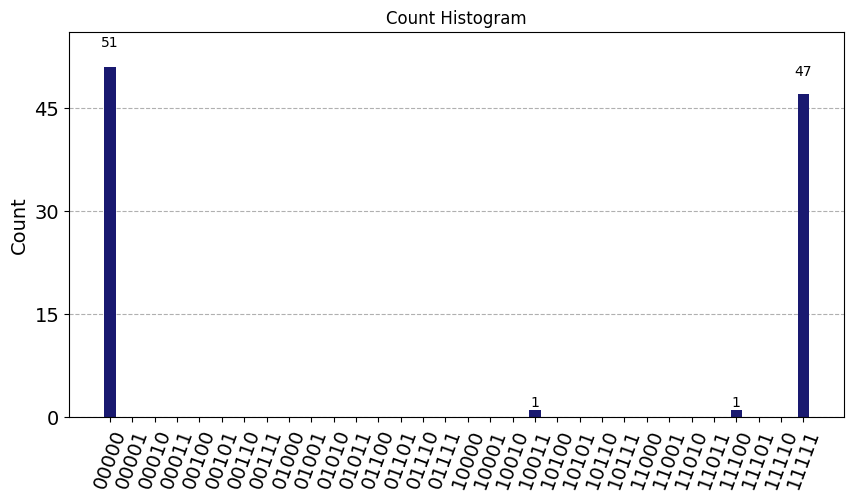

In [ ]:
dev2 = qml.device("default.qubit",  wires=nr_qubits, shots=100)

@qml.qnode(dev2)
def count_circuit(params):
    # repeatedly apply each layer in the circuit
    for j in range(nr_layers):
        layer_params = params[3*nr_qubits*j : 3*nr_qubits*(j+1)]
        layer(layer_params)
    return qml.counts(all_outcomes=True)

counts = count_circuit(best_params)
# print((counts))

plot_histogram(counts, color='midnightblue', title="Count Histogram", figsize=(10, 5))


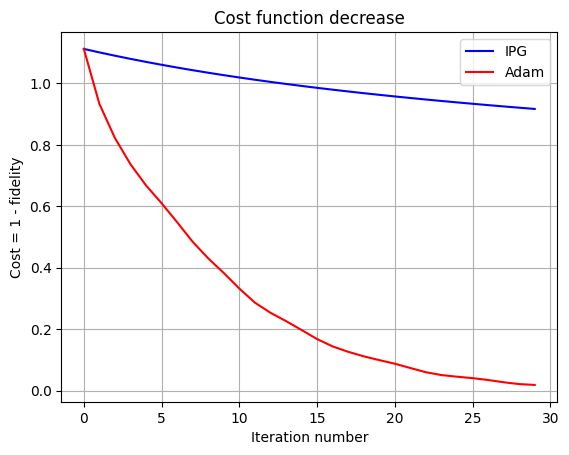

In [ ]:
plt.plot(loss_hist, color='b', label="IPG")
plt.plot(adam_loss_hist, color='r', label='Adam')
plt.grid()
plt.title("Cost function decrease")
plt.xlabel("Iteration number")
plt.ylabel("Cost = 1 - fidelity")
plt.legend()